In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

# Data: CelebA

## Dataset

In [2]:
from src.modules.celeba_data_module import CelebADataset, CelebA_DataModule
from src.tools.dataset_tools import get_dataset_filename_map, dataset_gdrive_download, get_labels
import config_celeba
import os
import numpy as np

# download celeba dataset
dataset_gdrive_download(config = config_celeba)

# get labels map
labels_map = get_labels(config = config_celeba)

print('Number of class in label map', len(list(labels_map.keys())) )
# print()
# print('Number of samples per person')
# for i, (k, v) in enumerate(list(labels_map.items())):
#     print(len(v))
#     if i >5:
#         break
print('\ntesting dataset')

num_classes=10

dataset = CelebADataset(labels_map, num_classes=num_classes)
print('nb samples', len(dataset))
print('nb classes in dataloader', dataset.nb_classes())
print(np.unique(dataset.ys))

Dataset already downloaded
Labels already downloaded
Number of class in label map 10177

testing dataset
nb samples 202
nb classes in dataloader 10
[ 1  2  3  4  5  6  7  8  9 10]


 Train dataset ----------------------------




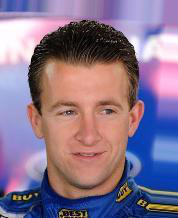

label 1
shape (178, 218)




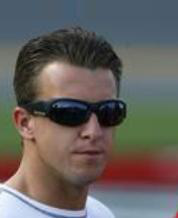

label 1
shape (178, 218)


In [3]:
#image from train dataset
print(" Train dataset ----------------------------")
for i, (image, label) in enumerate(dataset):
    print("\n")
    display(image)
    print("label",label)
    print('shape', image.size)
    if i==1:
        break


## Dataloader with custom sampler

In [4]:
import multiprocessing as mp

num_classes_iter = 4
batch_size = 16
dataloader = CelebA_DataModule(dataset, batch_size = batch_size, num_classes_iter=num_classes_iter,
                               splitting_points=(0.10, 0.10),  input_shape = (3, 256, 256), 
                               num_workers = mp.cpu_count())

dataloader.setup()

train_loader = dataloader.train_dataloader()
val_loader = dataloader.val_dataloader()
test_loader = dataloader.test_dataloader()

print("Number of train batches", len(train_loader))
print("Number of valid batches", len(val_loader))
print("Number of test batches", len(test_loader))

Number of train batches 0
Number of valid batches 2
Number of test batches 2


max value 1.0
min value 0.0
shape torch.Size([16, 3, 256, 256])
[tensor(5), tensor(5), tensor(5), tensor(5)]
[tensor(8), tensor(8), tensor(8), tensor(8)]
[tensor(1), tensor(1), tensor(1), tensor(1)]
[tensor(10), tensor(10), tensor(10), tensor(10)]


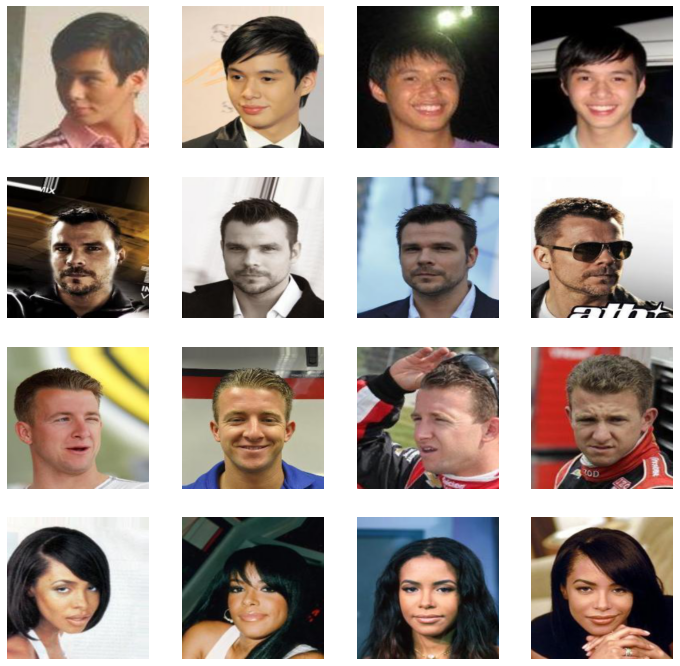

In [6]:
#Dataloader samples
from src.tools.visualization_tools import visualize_torch
import torch

n_row = num_classes_iter
n_cols = int(batch_size/num_classes_iter)

for i, (im, label) in enumerate(train_loader):
    print('max value', torch.max(im).item())
    print('min value', torch.min(im).item())
    print('shape', im.shape)
    visualize_torch(im, n_cols=n_cols, n_rows=n_row)
    for j in range(0, len(label), 4):
        print(list(label[j:j+4]))
    
    if i == 0:
        break

In [ ]:
model_hparams = {
        "loss_fn": ContrastiveLoss(),
        "lr": 0.001,
        "weight_decay":1e-5,
        "filter_channels": 4,
        "filter_size": 3,
        "dropout": 0.02,
        "n_hidden1": 4096,
        "n_hidden2": 2048,
        "n_hidden3": 128,
        'loss_margin': 5,
        'temperature': 1,
        'num_labeled_points_class': 2
    }